<a href="https://colab.research.google.com/github/Plixelated/sky_transparency_model_testing/blob/main/Transparency_Model_Data_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
seed = 42

###Load and Clean Dataset

In [ ]:
df = pd.read_csv('/content/transparency_model_dataset.csv')
df = df.drop(columns='time')
attributes = df.drop(columns=['transparency_forecast (0-5)','transparency_forecast_age (hrs)','seeing_forecast_age (hrs)','seeing_forecast (0-5)'])
target = df["transparency_forecast (0-5)"]
print(attributes.shape)
print(target.shape)

(9106, 73)
(9106,)


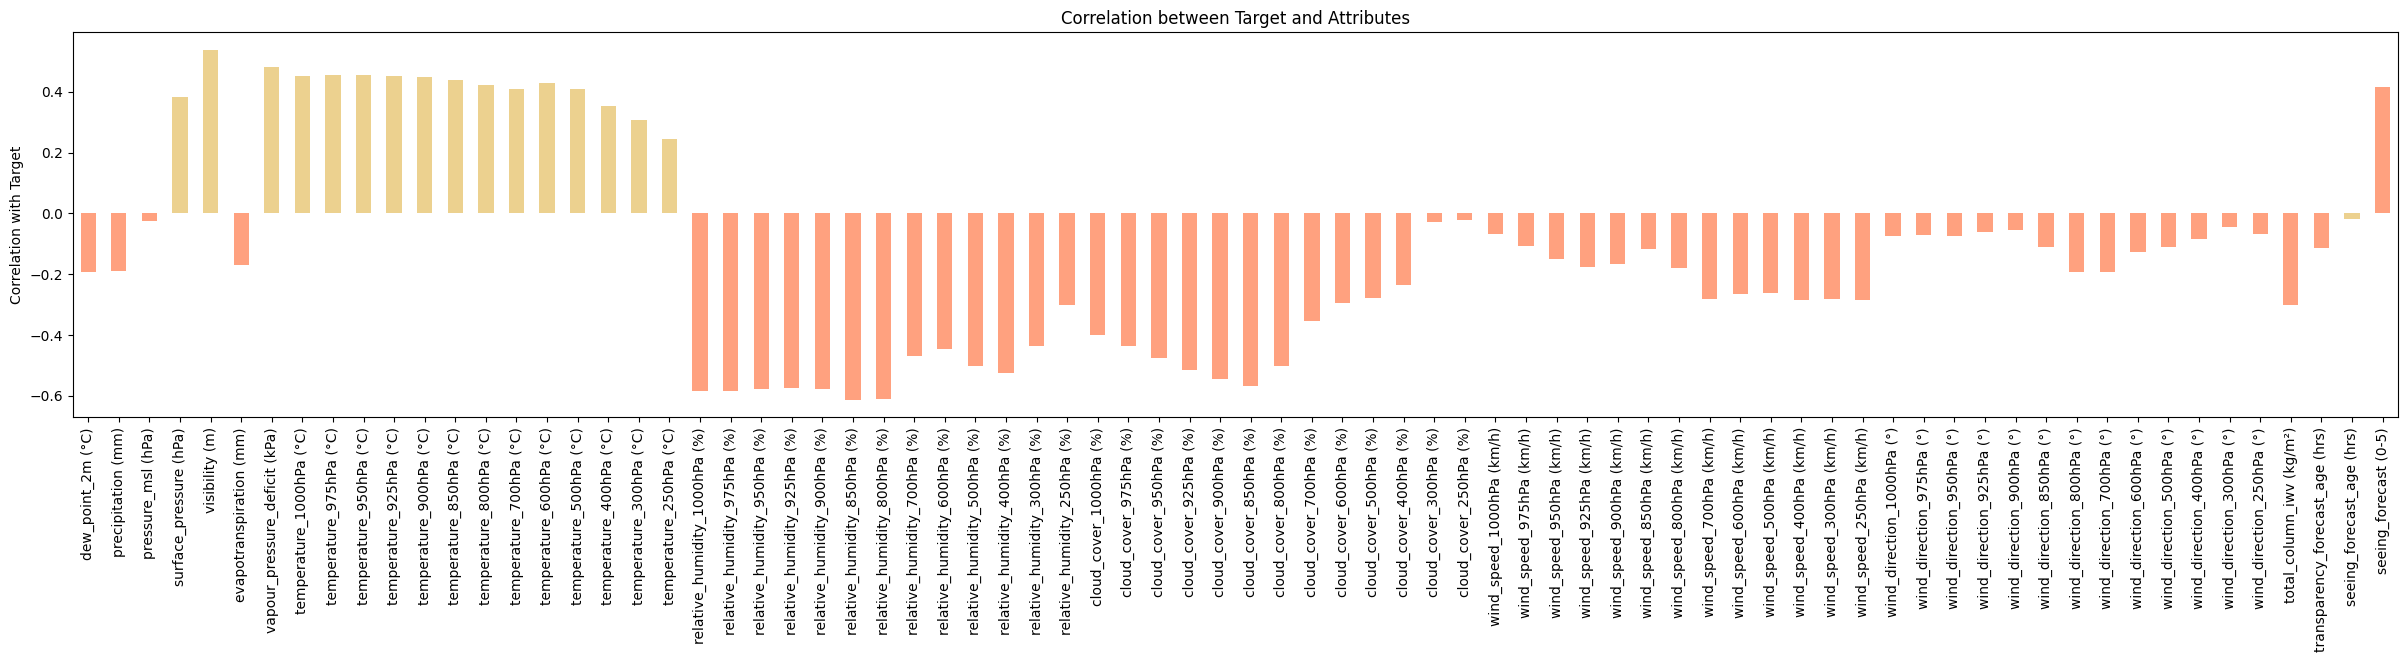

In [ ]:
#@title Fig 23: Feature Correlation Visualization

def bar_color(df,color1,color2):
    return np.where(df.values>0,color1,color2).T

plt.figure(figsize=(30,5))
correlations = df.rename(columns = {"total_column_integrated_water_vapour (kg/m²)": "total_column_iwv (kg/m²)"})
#print(correlations.columns)
correlations = correlations.corrwith(df['transparency_forecast (0-5)'])

correlations.drop('transparency_forecast (0-5)').plot.bar(color=bar_color(correlations,'goldenrod','orangered'), alpha=0.5)
plt.ylabel('Correlation with Target')
plt.title('Correlation between Target and Attributes')

plt.show()

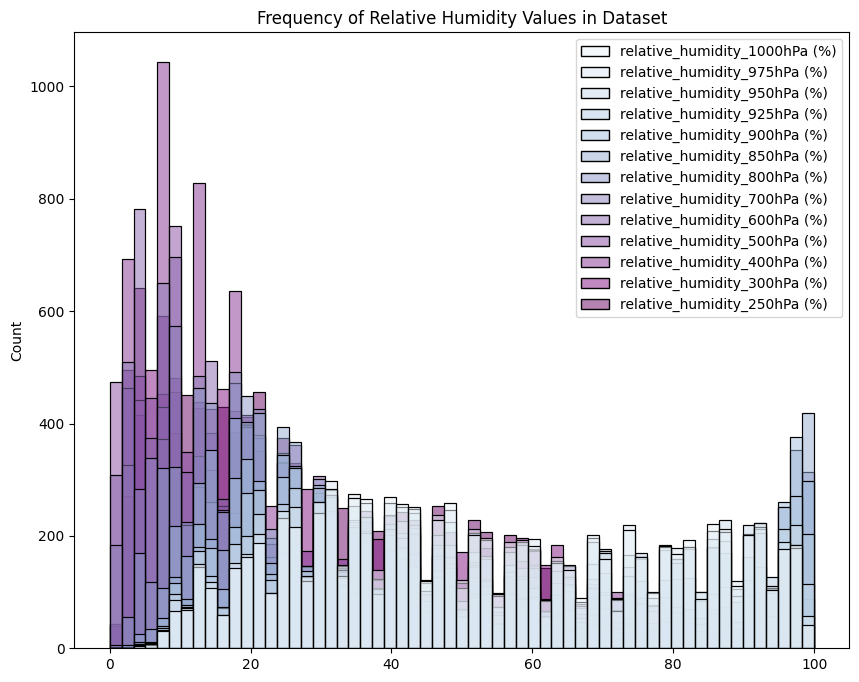

In [ ]:
#@title Fig 3: Relative Humidity Frequency
#Frequency
plt.figure(figsize=(10,8))
rh_col = [entry for entry in df.columns if 'relative' in entry]
rh_subset = df[[col for col in rh_col]]

sns.histplot(rh_subset,palette = "BuPu")

plt.title("Frequency of Relative Humidity Values in Dataset")
plt.show()

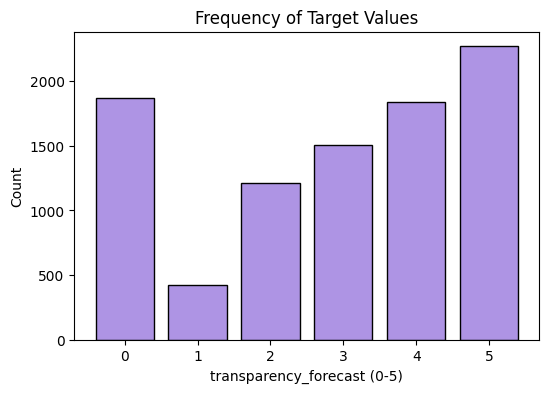

In [ ]:
#@title Fig 4: Target Value Visualization

plt.figure(figsize=(6,4))

sns.histplot(df['transparency_forecast (0-5)'],color='mediumpurple',discrete=True,shrink=0.8)
plt.title("Frequency of Target Values")
plt.show()

###Min/Max Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
attributes_normal = scaler.fit_transform(attributes.values)

###Principle Comoponent Analysis

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components = 10)
attributes_pca = pca.fit_transform(attributes_normal)

In [ ]:
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Values:",explained_variance)
print('Total Dataset Retained:',sum(explained_variance))

Explained Variance Values: [0.35944801 0.13752239 0.09267335 0.05602033 0.05050156 0.04527213
 0.02777496 0.02685713 0.02423632 0.01622504]
Total Dataset Retained: 0.8365312065549084


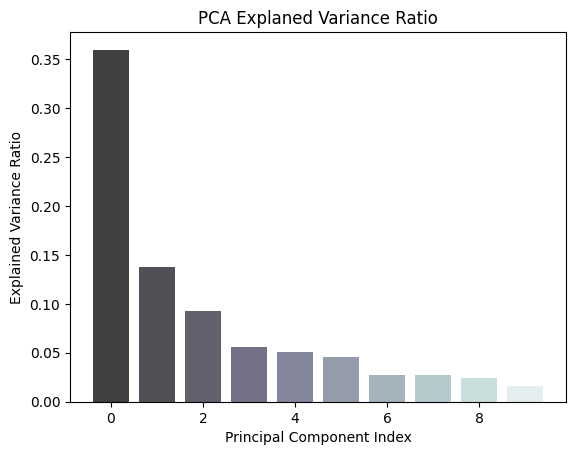

In [ ]:
#@title Fig 7: PCA Component Visualization

cmap = plt.get_cmap('bone')
# Generate colors for each bar
colors = [cmap(i / len(pca.explained_variance_ratio_)) for i in range(len(pca.explained_variance_ratio_))]

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, color=colors,alpha=0.75)

plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")

plt.title("PCA Explaned Variance Ratio")
plt.show()

###**Train/Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
from matplotlib.ticker import PercentFormatter

In [ ]:
#@title Non-PCA Split
X_train, X_test, y_train, y_test = train_test_split(
    attributes_normal, target.values, test_size=0.3, stratify=target.values, random_state=seed)

In [ ]:
#@title PCA Split
X_train, X_test, y_train, y_test = train_test_split(
    attributes_pca, target.values, test_size=0.3, stratify=target.values, random_state=seed)

###**Resampling**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
oversampler = RandomOverSampler(random_state=seed)
X_train_resample, y_train_resample = oversampler.fit_resample(X_train, y_train)

In [ ]:
print(X_train_resample.shape)
print(y_train_resample.shape)

(9528, 73)
(9528,)


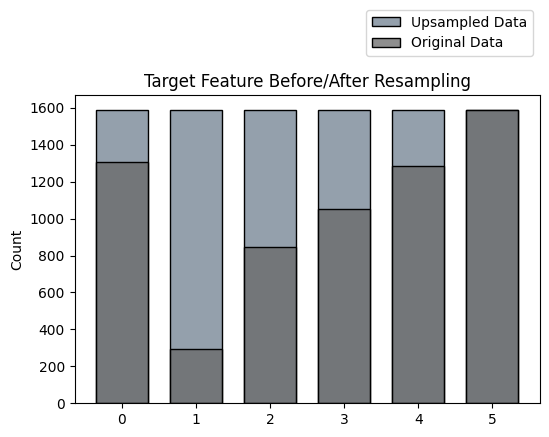

In [ ]:
#@title Fig 8: Resampling Visualization
plt.figure(figsize=(6,4))


sns.histplot(y_train_resample,color='slategrey', discrete=True,shrink=0.7,label='Upsampled Data')
sns.histplot(y_train,color='dimgrey', discrete=True,shrink=0.7,label='Original Data')
plt.title("Target Feature Before/After Resampling")
plt.legend(bbox_to_anchor=(1, 1.3), loc='upper right')
plt.show()

###Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Tree Visualization
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [ ]:
rfc = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,max_features='sqrt',
    n_estimators=300,
    random_state=seed)
rfc.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=300,
                       random_state=42)

In [ ]:
# Extract feature importances
importances = rfc.feature_importances_
feature_names = attributes.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Rank features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
feature_importance_df

,Feature,Importance
20,relative_humidity_1000hPa (%),0.064025
25,relative_humidity_850hPa (%),0.057887
30,relative_humidity_400hPa (%),0.053969
21,relative_humidity_975hPa (%),0.049959
31,relative_humidity_300hPa (%),0.048210
...,...,...
41,cloud_cover_600hPa (%),0.001931
43,cloud_cover_400hPa (%),0.001636
5,evapotranspiration (mm),0.000164
44,cloud_cover_300hPa (%),0.000000


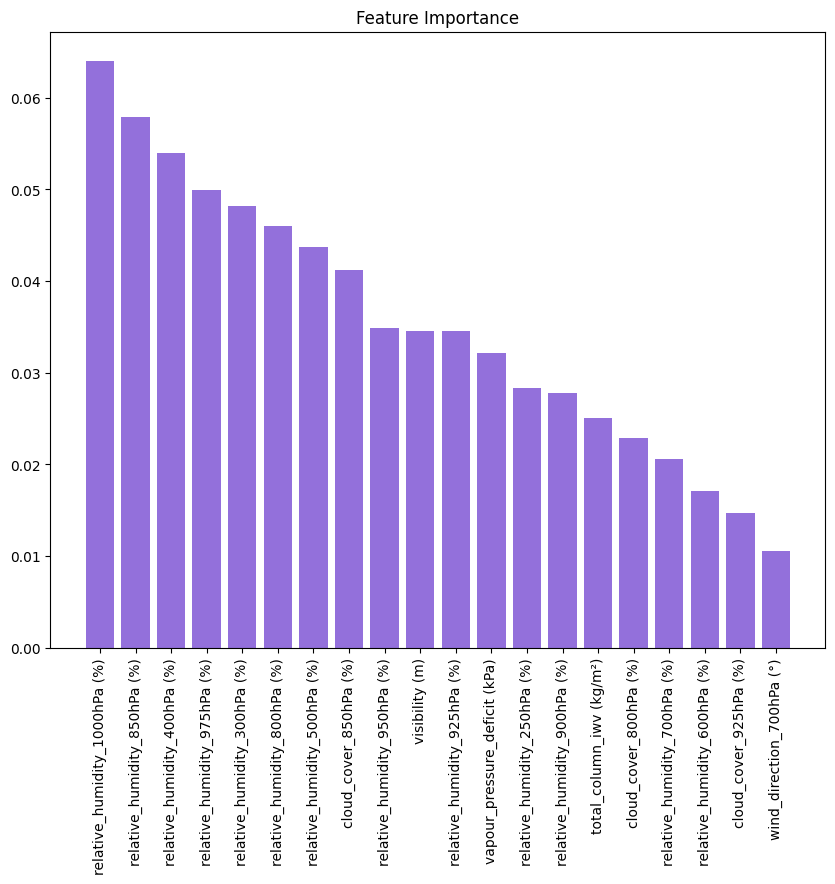

In [ ]:
#@title Fig 2: Top Features

features = feature_importance_df.replace(
    {'Feature':
    {
        "total_column_integrated_water_vapour (kg/m²)":
        "total_column_iwv (kg/m²)"
        }
    })
top_features = features[:20]
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
plt.bar(top_features['Feature'],top_features['Importance'],color='mediumpurple')
plt.title("Feature Importance")
plt.show()

###Tree Visualizations

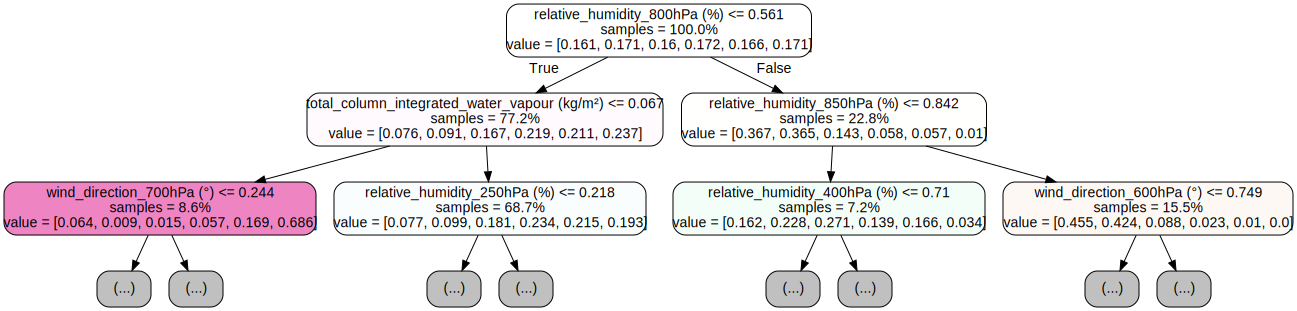

In [ ]:
#@title Fig 9: Random Forest Tree Visualizer

tree = rfc.estimators_[0]
dot_data = export_graphviz(tree,
                            feature_names=attributes.columns,
                            filled=True,
                            rounded = True,
                            max_depth=2,
                            impurity=False,
                            proportion=True)
graph = graphviz.Source(dot_data)
graph.render(f'rfc_tree_{0}', format='png')
display(graph)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
#Create Gradient Boosting Model with Hyperparameters
gradient_booster = GradientBoostingClassifier(
    n_estimators=1000,
    max_depth = 5,
    random_state = seed,
    learning_rate=0.1,
    validation_fraction=0.1,
    n_iter_no_change=10,
    min_samples_split=50,
    min_samples_leaf=50)
gradient_booster.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=5, min_samples_leaf=50,
                           min_samples_split=50, n_estimators=1000,
                           n_iter_no_change=10, random_state=42)

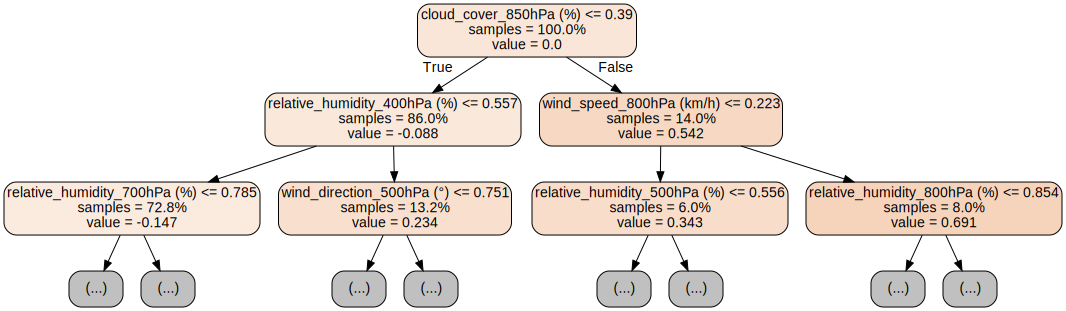

In [ ]:
#@title Fig 10: Gradient Boost Tree Visualizer

first_tree = gradient_booster.estimators_[0][0]
dot_data = export_graphviz(first_tree,
                            feature_names=attributes.columns,
                            filled=True,
                            rounded = True,
                            max_depth=2,
                            impurity=False,
                            proportion=True)
graph = graphviz.Source(dot_data)
graph.render('gradient_boost_tree', format='png')
graph